<a href="https://colab.research.google.com/github/Hacxmr/log-analysis/blob/main/UNSW_NB15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn tensorflow

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

train_df = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('/content/UNSW_NB15_testing-set.csv')

train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#Identify feature and label columns
label_col = 'label'
X_train_all = train_df.drop(columns=[label_col])
y_train_all = train_df[label_col]

X_test = test_df.drop(columns=[label_col])
y_test = test_df[label_col]

# Step 2: Use only normal samples (label=0) for training
X_train_normal = X_train_all[y_train_all == 0]

# Step 3: Identify categorical and numeric columns
categorical_cols = X_train_all.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train_all.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 4: Build preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Step 5: Fit-transform training data and transform test data
X_train_scaled = preprocessor.fit_transform(X_train_normal)
X_test_scaled = preprocessor.transform(X_test)

In [6]:
input_dim = X_train_scaled.shape[1]
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=20, batch_size=256, validation_split=0.1
)


Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.3835 - val_loss: 0.4253
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0658 - val_loss: 0.2062
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0297 - val_loss: 0.1109
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0181 - val_loss: 0.0843
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0688
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0619
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0546
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0508
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0460
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - val_loss: 0.0473
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0418
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [7]:
# Predict on test set
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.square(X_test_scaled - reconstructions), axis=1)

# Choose a threshold (e.g., 95th percentile of reconstruction error on normal data)
threshold = np.percentile(mse[y_test == 0], 95)

# Predict: 1 = anomaly, 0 = normal
y_pred = (mse > threshold).astype(int)

# Evaluate
print("Threshold used:", threshold)
print(classification_report(y_test, y_pred))


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Threshold used: 0.013107098189601636
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     37000
           1       0.96      1.00      0.98     45332

    accuracy                           0.98     82332
   macro avg       0.98      0.97      0.98     82332
weighted avg       0.98      0.98      0.98     82332



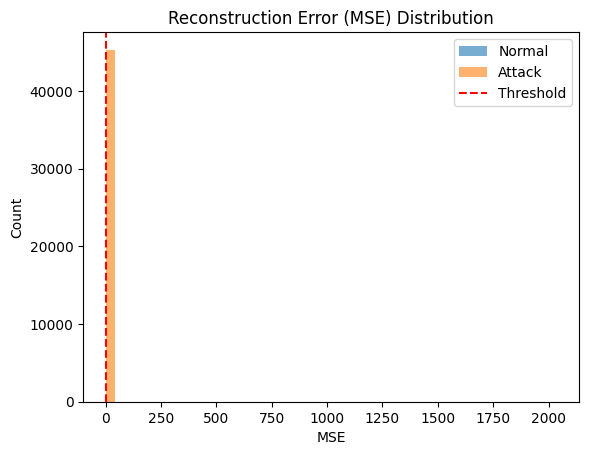

In [8]:
import matplotlib.pyplot as plt

plt.hist(mse[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse[y_test == 1], bins=50, alpha=0.6, label='Attack')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error (MSE) Distribution")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()
